In [4]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
import time
import seaborn as sns
from keras.models import Sequential

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline

In [5]:
def mean_relative_error(target_values, predicted_values):
    return sum(abs(target_values - predicted_values))/sum(target_values)

def median_relative_error(target_values, predicted_values):
    return np.median(abs(target_values - predicted_values)/target_values)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_prediction_2(y_test, y_test_predicted, y_train, y_train_predicted) -> str:  
    test_mse = mean_squared_error(y_test, y_test_predicted)
    print('test_mse:', round(test_mse, 4))
    train_mse = mean_squared_error(y_train, y_train_predicted)
    print('train_mse:', round(train_mse, 4))
    test_rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
    print('test_rmse:', round(test_rmse, 4))
    train_rmse = mean_squared_error(y_train, y_train_predicted, squared=False)
    print('train_rmse:', round(train_rmse, 4))
    test_mae = mean_absolute_error(y_test, y_test_predicted)
    print('test_mae:', round(test_mae, 4))
    train_mae = mean_absolute_error(y_train, y_train_predicted)
    print('train_mae:', round(train_mae, 4))
    test_mre = mean_relative_error(y_test, y_test_predicted)
    print('test_mre:', round(test_mre, 4))
    train_mre = mean_relative_error(y_train, y_train_predicted)
    print('train_mre:', round(train_mre, 4))
    test_medAE = median_absolute_error(y_test, y_test_predicted)
    print('test_medAE:', round(test_medAE, 4))
    train_medAE = median_absolute_error(y_train, y_train_predicted)
    print('train_medAE:', round(train_medAE, 4))
    test_medRE = median_relative_error(y_test, y_test_predicted)
    print('test_medRE:', round(test_medRE, 4))
    train_medRE = median_relative_error(y_train, y_train_predicted)
    print('train_medRE:', round(train_medRE, 4))
    test_mape = mean_absolute_percentage_error(y_test, y_test_predicted)
    print('test_mape:', round(test_mape, 4))
    train_mape = mean_absolute_percentage_error(y_train, y_train_predicted)
    print('train_mape:', round(train_mape, 4))
    return evaluate_prediction_2
    #return f'{round(test_mse, 4)}; {round(train_mse, 4)}; {round(test_rmse, 4)}; {round(train_rmse, 4)}; {round(test_mae, 4)}; {round(train_mae, 4)}; {round(test_mre, 4)}; {round(train_mre, 4)}; {round(test_medAE, 4)}; {round(train_medAE, 4)}; {round(test_medRE, 4)}; {round(train_medRE, 4)}; {round(test_mape, 4)}; {round(train_mape, 4)}'

In [6]:
input_file = open("D:\Master\Projekt im Master\DataSet\joinedExportv4.csv", "r")
df = pd.read_csv(input_file)
#df = pd.read_csv(input_file, nrows = 1000)
df.head()

,Unnamed: 0,tripId,startLongitude_x,startLatitude_x,endLongitude_x,endLatitude_x,startTime,startTimeYear,startTimeMonth,startTimeWeek,...,endTGC1000IndexY,endTGC500IndexY,endTGC250IndexY,endTGC150IndexY,endTGC100IndexY,endTGC50IndexY,endTGC25IndexY,endTGC15IndexY,endTGC10IndexY,endTGC5IndexY
0,0,138,-73.965675,40.760399,-73.946228,40.747871,2016-02-01T00:00:54Z,2016,2,5,...,20,41,82,136,205,410,820,1367,2050,4101
1,1,145,-74.007629,40.740795,-73.980873,40.745068,2016-02-01T00:00:58Z,2016,2,5,...,20,40,80,134,201,402,805,1343,2014,4029
2,2,126,-73.986862,40.739311,-73.956688,40.771107,2016-02-01T00:00:44Z,2016,2,5,...,23,46,93,156,234,469,939,1565,2348,4697
3,3,106,-73.997856,40.751511,-74.004951,40.743313,2016-02-01T00:00:35Z,2016,2,5,...,19,39,79,132,199,398,796,1328,1992,3984
4,4,167,-73.965324,40.766071,-73.941017,40.788322,2016-02-01T00:01:08Z,2016,2,5,...,25,51,102,171,256,513,1027,1712,2569,5138


In [7]:
newdf = df.rename(columns= {'timeBin20WWDSId': 'TripStartTime', 'startSGC15IndexX' : 'Pickup X-axis', 'startSGC15IndexY' : 'Pickup Y-axis', 'endSGC15IndexX' : 'Dropoff X-axis', 'endSGC15IndexY' : 'Dropoff Y-axis'})

In [36]:
feature_set = ['startTimeWeek', 'startTimeDay', 'TripStartTime', 'weatherHourlyTemp', 'weatherHourlyWind', 'weatherHourlyHumidity', 'weatherHourlyBarometer', 'Pickup X-axis', 'Pickup Y-axis', 'Dropoff X-axis', 'Dropoff Y-axis']
y_f = 'tripDuration'
sample_size = 1400000

In [37]:
dataset = newdf[feature_set + [y_f]].sample(sample_size)

train_dataset = dataset.sample(frac=0.8958165367732689, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
    
train_features = train_dataset.copy()
test_features = test_dataset.copy()
    
train_labels = train_features.pop(y_f)    
test_labels = test_features.pop(y_f)


In [38]:
def train_MLR():
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(train_features))

    global linear_model
    linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])

    linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

    global start
    start = int(time.time())
    
    global end
    end = int(time.time())
    
    return linear_model




estimator = KerasRegressor(build_fn= train_MLR, epochs=60, verbose=0, validation_split = 0.2)
history = estimator.fit(train_features, train_labels)

y_test_predicted = linear_model.predict(test_features).flatten()
y_train_predicted = linear_model.predict(train_features).flatten()

eval_results = evaluate_prediction_2(test_labels, y_test_predicted, train_labels, y_train_predicted)
print(f';MLR; AllSelected; {int(end-start)};{eval_results}')
print("Test R2 score: {:.2f}".format(estimator.score(test_features, test_labels))) 

test_mse: 250635.6769
train_mse: 249733.0219
test_rmse: 500.6353
train_rmse: 499.733
test_mae: 364.9883
train_mae: 363.8565
test_mre: 0.4624
train_mre: 0.4612
test_medAE: 277.1556
train_medAE: 276.0973
test_medRE: 0.407
train_medRE: 0.4065
test_mape: 70.6041
train_mape: 70.979
;MLR; AllSelected; 0;<function evaluate_prediction_2 at 0x000001EBAC7A78B0>
Test R2 score: -364.99


Text(0, 0.5, 'Predicion Samples (Estimated time in seconds)')

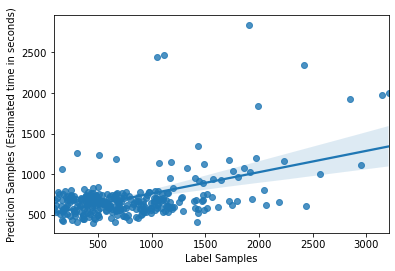

In [39]:
sampley_test= test_labels[:300:]
sampley_predreal= y_test_predicted[:300:]
sns.regplot(x = sampley_test, y = sampley_predreal)
plt.xlabel("Label Samples")
plt.ylabel("Predicion Samples (Estimated time in seconds)")

In [40]:
len(test_labels), len(y_test_predicted)

(145857, 145857)

In [41]:
for i in range(0,20):
    print(y_test_predicted[i], "vs", test_labels.iloc[i])

709.51373 vs 461
718.68994 vs 200
761.8287 vs 137
661.822 vs 437
1127.385 vs 1488
566.5651 vs 734
756.4572 vs 1516
806.0231 vs 246
608.58044 vs 329
709.9728 vs 1039
588.20667 vs 705
2471.324 vs 1110
405.7826 vs 304
763.3165 vs 1142
698.5095 vs 1935
2835.6987 vs 1903
658.0291 vs 305
679.54297 vs 1417
499.014 vs 357
505.2499 vs 183


In [42]:
len(y_test_predicted)

145857

In [43]:
test_labels.iloc[1]

200

In [16]:
y_test_predicted[1], test_labels.iloc[1]

(87.0573, 1823)

# Feature Importance using SHAP

In [37]:
import shap
shap.initjs()

In [38]:
test_features.head()

,startTimeWeek,startTimeDay,TripStartTime,weatherHourlyTemp,weatherHourlyWind,weatherHourlyHumidity,weatherHourlyBarometer,Pickup X-axis,Pickup Y-axis,Dropoff X-axis,Dropoff Y-axis
849693,5,3,59,14,15,87,1010,766,1305,709,1330
391305,5,2,31,8,11,40,1027,621,1149,611,1232
1432875,5,5,56,2,7,44,1024,556,1164,558,1242
985602,5,4,28,11,6,55,1016,772,1394,629,1370
56929,5,1,24,11,9,56,1009,751,1445,702,1340


In [39]:
#2D numpy array for shap
def wrapper(X):
    return estimator.predict(X).flatten()

In [40]:
#explainer = shap.KernelExplainer(wrapper, test_features)
#Using 145857 background data samples could cause slower run times. 
#Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.

#X_test_sample = test_features.sample(10000)
#shap_values  = explainer.shap_values(X_test_sample)
#MemoryError: Unable to allocate 24.5 GiB for an array with shape (2046, 1604427) and data type int64

In [41]:
X_test_summary = shap.sample(test_features,100)

In [42]:
explainer = shap.KernelExplainer(wrapper, X_test_summary)

In [43]:
X_test_sample = test_features.sample(1000)

In [44]:
shap_values  = explainer.shap_values(X_test_sample)

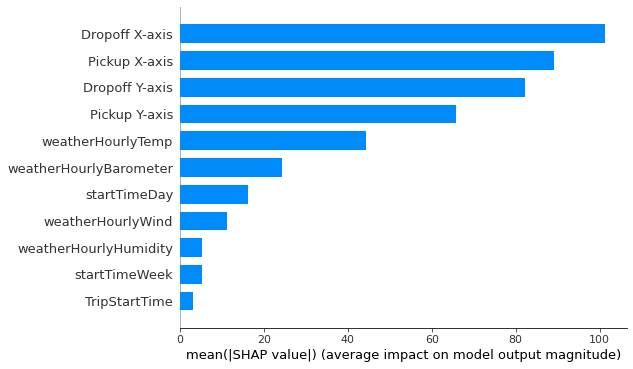

In [45]:
shap.summary_plot(shap_values, X_test_sample,plot_type="bar")

Additive explainer: 1001it [00:36, 20.25it/s]                                                                          


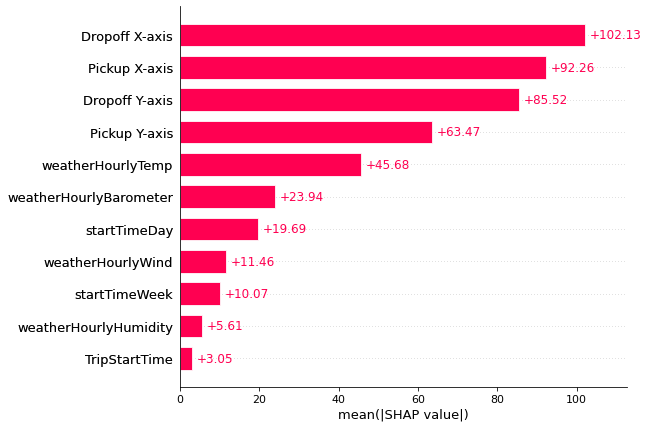

In [49]:
explainer1 = shap.AdditiveExplainer(wrapper, X_test_sample)
shap_values1  = explainer1(X_test_sample)
shap.plots.bar(shap_values1, max_display=11)

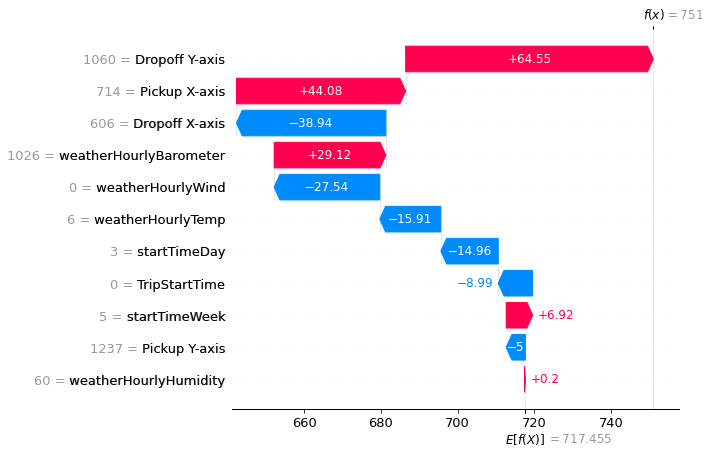

In [50]:
shap.plots.waterfall(shap_values1[0], max_display=11)

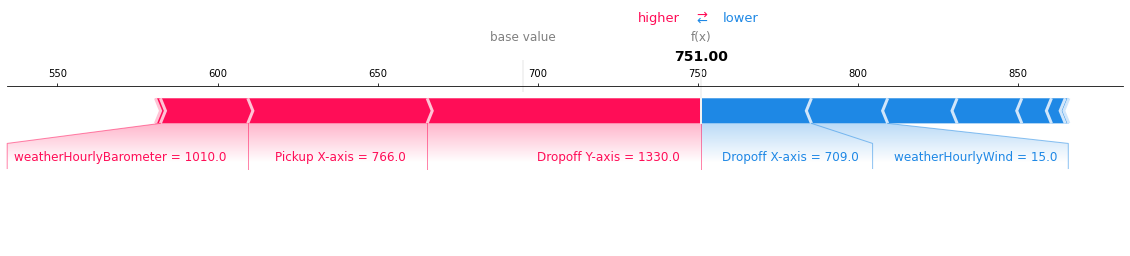

In [51]:
shap.force_plot(explainer.expected_value, shap_values[0], test_features.iloc[0],feature_set,matplotlib=True, show=True)

In [52]:
test_features.iloc[0]

startTimeWeek                5
startTimeDay                 3
TripStartTime               59
weatherHourlyTemp           14
weatherHourlyWind           15
weatherHourlyHumidity       87
weatherHourlyBarometer    1010
Pickup X-axis              766
Pickup Y-axis             1305
Dropoff X-axis             709
Dropoff Y-axis            1330
Name: 849693, dtype: int64

In [53]:
y_test_predicted.mean()

699.2535

# PDPs

In [44]:
from pdpbox import pdp, get_dataset, info_plots

In [45]:
feature_set

['startTimeWeek',
 'startTimeDay',
 'TripStartTime',
 'weatherHourlyTemp',
 'weatherHourlyWind',
 'weatherHourlyHumidity',
 'weatherHourlyBarometer',
 'Pickup X-axis',
 'Pickup Y-axis',
 'Dropoff X-axis',
 'Dropoff Y-axis']

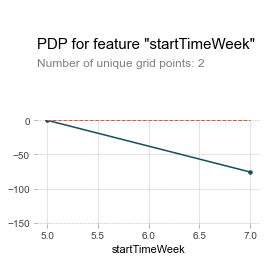

In [46]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'startTimeWeek')

pdp.pdp_plot(pdp_MLR, 'startTimeWeek', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

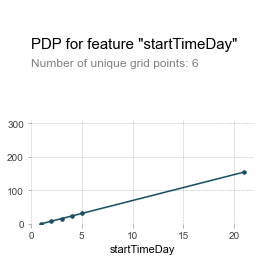

In [47]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'startTimeDay')

pdp.pdp_plot(pdp_MLR, 'startTimeDay', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

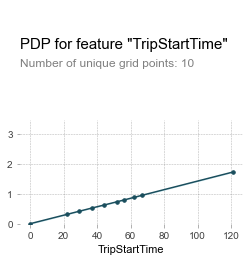

In [48]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'TripStartTime')

pdp.pdp_plot(pdp_MLR, 'TripStartTime', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

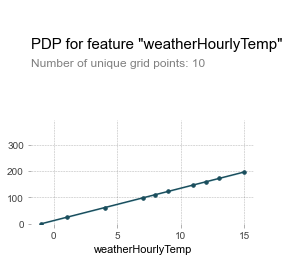

In [49]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyTemp')

pdp.pdp_plot(pdp_MLR, 'weatherHourlyTemp', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

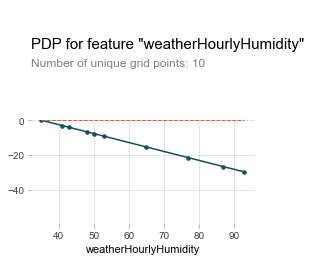

In [50]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyHumidity')

pdp.pdp_plot(pdp_MLR, 'weatherHourlyHumidity', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

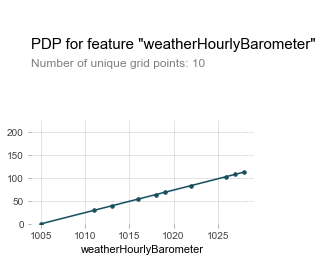

In [51]:
pdp_MLR = pdp.pdp_isolate(model = estimator,
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyBarometer')

pdp.pdp_plot(pdp_MLR, 'weatherHourlyBarometer', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

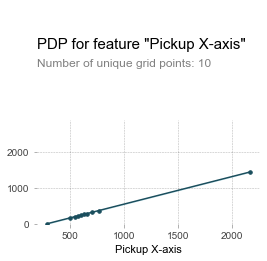

In [52]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Pickup X-axis')

pdp.pdp_plot(pdp_MLR, 'Pickup X-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

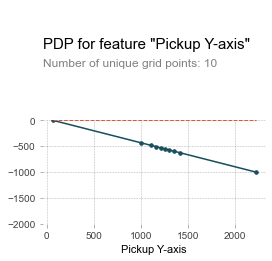

In [53]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Pickup Y-axis')

pdp.pdp_plot(pdp_MLR, 'Pickup Y-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

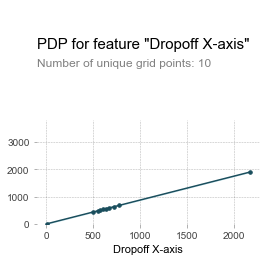

In [54]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Dropoff X-axis')

pdp.pdp_plot(pdp_MLR, 'Dropoff X-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

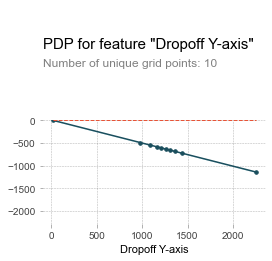

In [55]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Dropoff Y-axis')

pdp.pdp_plot(pdp_MLR, 'Dropoff Y-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

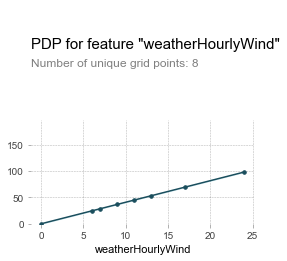

In [56]:
pdp_MLR = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyWind')
                               

pdp.pdp_plot(pdp_MLR, 'weatherHourlyWind', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

# Feature Importance using Eli5

In [57]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction

In [58]:
perm = PermutationImportance(estimator, random_state=1).fit(train_features, train_labels)
#perm = PermutationImportance(estimator).fit(train_features, train_labels)

In [59]:
eli5.show_weights(perm, feature_names = test_features.columns.tolist())

Weight,Feature
28.8503 ± 0.2184,Dropoff X-axis
27.3670 ± 0.2288,Pickup X-axis
19.1175 ± 0.1429,Dropoff Y-axis
12.2752 ± 0.1408,Pickup Y-axis
5.8504 ± 0.1285,weatherHourlyTemp
1.7174 ± 0.0529,weatherHourlyBarometer
1.6502 ± 0.0632,startTimeDay
0.7821 ± 0.0435,weatherHourlyWind
0.5904 ± 0.0178,startTimeWeek
0.1727 ± 0.0146,weatherHourlyHumidity


In [ ]:
eli5.show_prediction(estimator, test_features.iloc[10], feature_names = feature_set, show_feature_values = False)

In [60]:
y_test_predicted[10]

588.20667

In [35]:
type(feature_set)

list